In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression , RidgeCV

from sklearn.metrics import mean_absolute_error , mean_squared_error

In [22]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

from lls import LLS
from train_test_split import TTS

In [77]:
df = pd.read_csv("input/HousePrice.csv")
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


## Preprocessing

### Data Cleaning

In [78]:
df.describe()

,Area,Room,Price,Price(USD)
count,3265.000000,3265.000000,3.265000e+03,3.265000e+03
mean,107.543645,2.086371,5.450657e+09,1.816886e+05
std,70.734379,0.763691,8.249013e+09,2.749671e+05
min,30.000000,0.000000,3.600000e+06,1.200000e+02
25%,70.000000,2.000000,1.417500e+09,4.725000e+04
50%,90.000000,2.000000,2.950000e+09,9.833333e+04
75%,121.000000,2.000000,6.100000e+09,2.033333e+05
max,929.000000,5.000000,9.240000e+10,3.080000e+06


In [79]:
print(df.isnull().sum())

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64


In [80]:
df = df.dropna(subset=['Address'])
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33
...,...,...,...,...,...,...,...,...
3260,63,1,True,True,False,Feiz Garden,1.890000e+09,63000.00
3261,86,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67
3262,83,2,True,True,True,Niavaran,6.800000e+09,226666.67
3263,105,2,True,True,True,Dorous,5.600000e+09,186666.67


### Update dollar price to October 2024

In [81]:
df['Price(USD)'] = df['Price(USD)'] * 2
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,123333.34
1,60,1,True,True,True,Shahran,1.850000e+09,123333.34
2,79,2,True,True,True,Pardis,5.500000e+08,36666.66
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,60166.66
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,466666.66


In [82]:
df_sorted = df.sort_values(by='Price', ascending=False , ignore_index=True)
top_5_expensive_houses = df_sorted.head(5)
top_5_expensive_houses = top_5_expensive_houses[["Address", "Price"]]
print(top_5_expensive_houses)

      Address         Price
0  Zaferanieh  9.240000e+10
1      Abazar  9.100000e+10
2     Lavasan  8.500000e+10
3  Ekhtiarieh  8.160000e+10
4    Niavaran  8.050000e+10


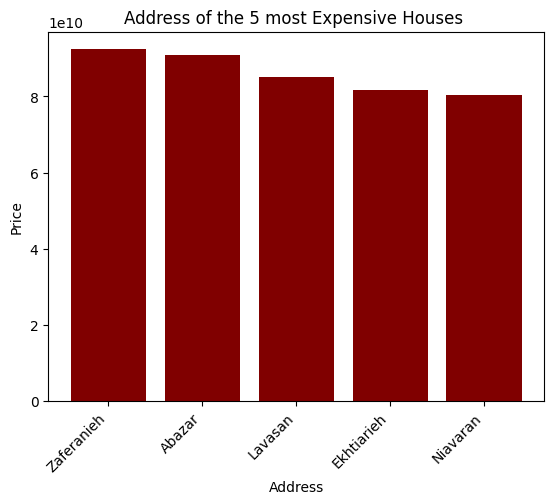

In [83]:
plt.bar(top_5_expensive_houses["Address"],
        top_5_expensive_houses["Price"], color="Maroon")
plt.title("Address of the 5 most Expensive Houses ")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Address")
plt.ylabel("Price")
plt.show()

## Process

### Train and Test

In [12]:
df.drop(["Address"], inplace=True, axis=1)
df.head()

,Area,Room,Parking,Warehouse,Elevator,Price,Price(USD)
0,63,1,True,True,True,1.850000e+09,123333.34
1,60,1,True,True,True,1.850000e+09,123333.34
2,79,2,True,True,True,5.500000e+08,36666.66
3,95,2,True,True,True,9.025000e+08,60166.66
4,123,2,True,True,True,7.000000e+09,466666.66


Correlation

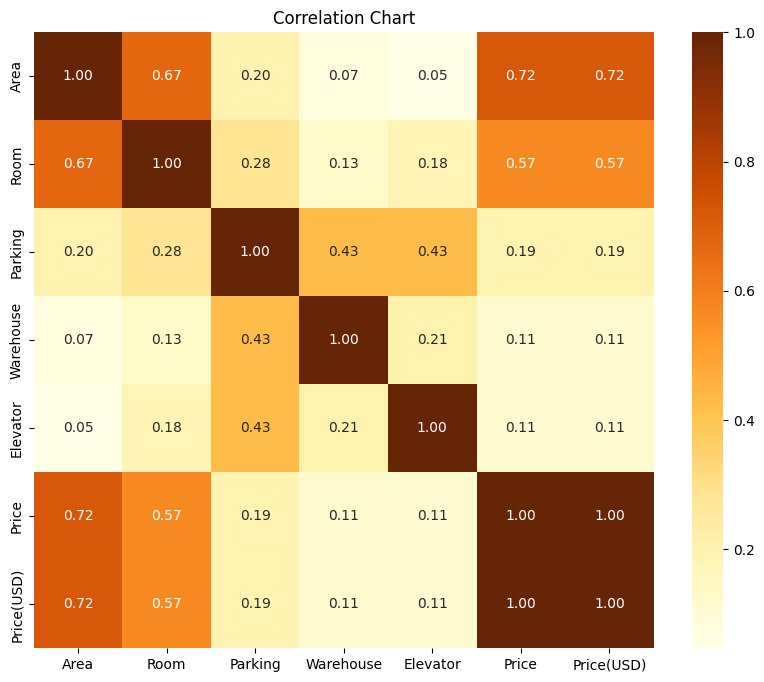

In [18]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr', fmt='.2f')
plt.title('Correlation Chart')
plt.show()

In [58]:
X = np.array(df.drop(columns=['Warehouse','Elevator', 'Price', 'Price(USD)']))
X

array([[63, 1, True],
       [60, 1, True],
       [79, 2, True],
       ...,
       [83, 2, True],
       [105, 2, True],
       [82, 2, False]], dtype=object)

In [59]:
y = np.array(df['Price'])
y

array([1.85e+09, 1.85e+09, 5.50e+08, ..., 6.80e+09, 5.60e+09, 3.60e+08])

### Split train and test with TTS (my function)

In [60]:
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2594, 3)
(648, 3)
(2594,)
(648,)


In [65]:
X_train = X_train.astype(np.float64, copy=False)

### Linear Least Regression Modeling

In [63]:
lls = LLS()
lls.fit(X_train, y_train)

In [64]:
Y_pred = lls.predict(X_test)

Compare result of my LLS function with Scikit-Learn's results

In [86]:
MAE_loss = lls.evaluate(X_test, y_test, "mae")
MSE_loss = lls.evaluate(X_test, y_test, "mse")
RMSE_loss = lls.evaluate(X_test, y_test, "rmse")

print("LinearLeastSquare MAE =" , MAE_loss)
print("LinearLeastSquare MSE =" , MSE_loss)
print("LinearLeastSquare RMSE =" , RMSE_loss)

LinearLeastSquare MAE = 3089735246.556549
LinearLeastSquare MSE = 3.7002187134535e+19
LinearLeastSquare RMSE = 6082942308.992828


In [87]:
ridgecv_model = RidgeCV(alphas=tuple(np.logspace(-3, 0, num=4)))
ridgecv_model.fit(X_train, y_train)
y_pred_ridgcv = ridgecv_model.predict(X_test)
MAE_ridge = mean_absolute_error(y_test, y_pred_ridgcv)
MSE_ridge = mean_squared_error(y_test, y_pred_ridgcv)
RMSE_ridge = np.sqrt(MSE_ridge)

print("RidgeCV MAE =" , MAE_ridge)
print("RidgeCV MSE =" , MSE_ridge)
print("RidgeCV RMSE =" , RMSE_ridge)

RidgeCV MAE = 2927934644.352439
RidgeCV MSE = 3.3528996743783084e+19
RidgeCV RMSE = 5790422846.717075


In [89]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
Y_pred_linear = linear_model.predict(X_test)

MAE_linreg = mean_absolute_error(y_test, Y_pred_linear)
MSE_linreg = mean_squared_error(y_test, Y_pred_linear)
RMSE_linreg = np.sqrt(MSE_linreg)


print("LinearRegression MAE =" , MAE_linreg)
print("LinearRegression MSE =" , MSE_linreg)
print("LinearRegression RMSE =" , RMSE_linreg)

LinearRegression MAE = 2928317487.8436017
LinearRegression MSE = 3.3529333701534188e+19
LinearRegression RMSE = 5790451942.770459
